In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import medmnist
from medmnist import INFO, Evaluator
data_flag = 'bloodmnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 16
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
import torch.utils.data as data
import torchvision.transforms as transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

val_dataset = DataClass(split='val', download=download)

In [4]:
neu_train_dataset = DataClass(split = 'train', transform=data_transform)
neu_val_dataset = DataClass(split = 'val', transform=data_transform)
neu_test_dataset = DataClass(split = 'test', transform=data_transform)

In [5]:
import numpy as np
idx = (train_dataset.labels==6) 
neu_train_dataset.labels = train_dataset.labels[idx]
neu_train_dataset.imgs = train_dataset.imgs[idx.squeeze()]

idx = (val_dataset.labels==6) 
neu_val_dataset.labels = val_dataset.labels[idx]
neu_val_dataset.imgs = val_dataset.imgs[idx.squeeze()]

idx = (test_dataset.labels==6) 
neu_test_dataset.labels = test_dataset.labels[idx]
neu_test_dataset.imgs = test_dataset.imgs[idx.squeeze()]

In [6]:
train_loader = data.DataLoader(dataset=neu_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=neu_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=neu_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Simple VAE

In [7]:
class VAE(nn.Module):
    def __init__(self, img_shape, code_size):
        super(VAE, self).__init__()

        # encoder
        self.C, self.H, self.W = img_shape
        self.conv1 = nn.Conv2d(self.C, 32, kernel_size=3,  padding= "same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding= "same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,   padding= "same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding= "same")
        self.fc1 = nn.Linear(256, code_size)
        self.fc2 = nn.Linear(256, code_size)
        

        # decoder
        self.fc3 = nn.Linear(code_size, 2304)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding = 1)
        self.conv7 = nn.ConvTranspose2d(64, self.C, kernel_size=3, stride=2, padding=1, output_padding = 1)

    def sampling(self, mu, log_var):
        stddev = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(stddev)
        return mu + stddev*epsilon
    
    def forward(self, x):
        e1 = F.elu(self.conv1(x))
        m1 = F.max_pool2d(e1, kernel_size=2)
        
        e2 = F.elu(self.conv2(m1))
        m2 = F.max_pool2d(e2, kernel_size=2)
        
        e3 = F.elu(self.conv3(m2))
        m3 = F.max_pool2d(e3, kernel_size=2)
        
        e4 = F.elu(self.conv4(m3))
        m4 = F.max_pool2d(e4, kernel_size=2)
        
        f1 = m4.view(m4.size(0), -1) 
        
        mu = self.fc1(f1)
        logvar = self.fc2(f1)
        z = self.sampling(mu, logvar)
        
        d5 = self.fc3(z)
        
        d4 = d5.view(d5.size(0), 256, 3, 3)
        d3 = F.elu(self.conv5(d4))
        d2 = F.elu(self.conv6(d3))
        d1 = self.conv7(d2)
        return d1, mu, logvar

In [8]:
z_dim = 128
vae = VAE(img_shape = (3,28,28),code_size  = z_dim)

In [9]:
optimizer = torch.optim.Adamax(vae.parameters())
loss_fn = torch.nn.MSELoss()

In [13]:
def KLDivLoss(mean, log_var):
    """
    Implement KL div loss for Normal distribution with Standard Normal Distribution as reference probability distirbution

    Params
    ----------------------
    mean: Tensor
        mean tensor of candidate probability ditribution; shape: (Batch Size, Latent dim)
    
    log_var: Tensor
        log variance of the candidate probability distribution; shape: (Batch Size, Latent dim)

    Returns
    -----------------------
    Tensor
        average KL divergence loss for the batch of inputs; shape: Scalar Tensor
    """
    loss = None
    ### BEGIN SOLUTION
    loss =  -torch.mean(0.5 * torch.sum(1 + log_var - torch.square(mean) - torch.exp(log_var), dim = -1), dim = 0)
    ### END SOLUTION
    return loss

In [11]:
def train_one_epoch_vae(epoch_index, model):
    running_loss = 0.
    running_recon_loss = 0.
    running_kl_loss = 0.
    last_loss = 0.
    re_last_loss = 0.
    kl_last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs, mu, logvar = model(inputs)

        # Compute the loss and its gradients
        recon_loss = loss_fn(outputs, inputs)
        kl_loss = KLDivLoss(mu, logvar)
        loss = recon_loss + 0.3*kl_loss
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()

    last_loss = running_loss / len(train_loader) # loss per batch
    re_last_loss = running_recon_loss / len(train_loader) # loss per batch
    kl_last_loss = running_kl_loss / len(train_loader) # loss per batch
    print('Epoch {} loss: {} recon_loss: {} kl_loss: {}'.format(epoch_index, last_loss, re_last_loss, kl_last_loss))

    return last_loss



def train_vae(model, out_path):
    # Initializing in a separate cell so we can easily add more epochs to the same run
    epoch_number = 0

    N_EPOCHS = 80

    best_vloss = 1_000_000.

    for epoch in range(N_EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss  = train_one_epoch_vae(epoch_number, model)

        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        running_re_vloss =0.0
        running_kl_vloss = 0.0
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs, vmu, vlog_var = model(vinputs)
            
            v_recon_loss = loss_fn(voutputs, vinputs)
            v_kl_loss = KLDivLoss(vmu, vlog_var)
            vloss = v_recon_loss + v_kl_loss
            running_vloss += vloss
            running_re_vloss += v_recon_loss
            running_kl_vloss += v_kl_loss

        avg_vloss = running_vloss / (i + 1)
        re_avg_rloss = running_re_vloss / (i + 1)
        kl_avg_vloss = running_kl_vloss / (i + 1)
        print('LOSS train {} valid {} recon {} kl {}'.format(avg_loss, avg_vloss, re_avg_rloss, kl_avg_vloss))


        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), out_path)

        epoch_number += 1

In [81]:
train_vae(vae, 'simple_vae_pytorch_model_128_code_size')

EPOCH 1:
Epoch 0 loss: 0.01622373432763023 recon_loss: 0.016218959168875464 kl_loss: 4.7751562032370406e-06
LOSS train 0.01622373432763023 valid 0.01613292470574379 recon 0.016132591292262077 kl 3.3368638696629205e-07
EPOCH 2:
Epoch 1 loss: 0.016232094421268325 recon_loss: 0.0162318650607581 kl_loss: 2.2936561338202747e-07
LOSS train 0.016232094421268325 valid 0.016120392829179764 recon 0.016120145097374916 kl 2.475475753271894e-07
EPOCH 3:
Epoch 2 loss: 0.016259203760642302 recon_loss: 0.016259024704308952 kl_loss: 1.7905633335244165e-07
LOSS train 0.016259203760642302 valid 0.016167715191841125 recon 0.01616748981177807 kl 2.2607599703405867e-07
EPOCH 4:
Epoch 3 loss: 0.016259504845748618 recon_loss: 0.01625934435207754 kl_loss: 1.6049622260733524e-07
LOSS train 0.016259504845748618 valid 0.01618223451077938 recon 0.01618204452097416 kl 1.911769800244656e-07
EPOCH 5:
Epoch 4 loss: 0.01620887178442862 recon_loss: 0.01620872818214232 kl_loss: 1.4360483782937778e-07
LOSS train 0.0162088

LOSS train 0.016183828188693277 valid 0.01609218120574951 recon 0.01609213277697563 kl 4.8858613155289277e-08
EPOCH 39:
Epoch 38 loss: 0.016194592969976877 recon_loss: 0.01619454331645002 kl_loss: 4.9653526854841675e-08
LOSS train 0.016194592969976877 valid 0.01631886512041092 recon 0.01631881296634674 kl 5.2631669689162663e-08
EPOCH 40:
Epoch 39 loss: 0.01621556103433648 recon_loss: 0.016215512382300342 kl_loss: 4.8650760351827324e-08
LOSS train 0.01621556103433648 valid 0.016129253432154655 recon 0.016129205003380775 kl 4.998438996040022e-08
EPOCH 41:
Epoch 40 loss: 0.01619206316616029 recon_loss: 0.016192016332116844 kl_loss: 4.6836595022450513e-08
LOSS train 0.01619206316616029 valid 0.0160902701318264 recon 0.01609022356569767 kl 4.665482578047886e-08
EPOCH 42:
Epoch 41 loss: 0.016185006337265852 recon_loss: 0.016184954680757573 kl_loss: 5.166161141496777e-08
LOSS train 0.016185006337265852 valid 0.016051918268203735 recon 0.016051873564720154 kl 4.5508581791864344e-08
EPOCH 43:
E

Epoch 75 loss: 0.016167898962197648 recon_loss: 0.016167785245159716 kl_loss: 1.1371576216436564e-07
LOSS train 0.016167898962197648 valid 0.016103528439998627 recon 0.016103439033031464 kl 9.009607992993551e-08
EPOCH 77:
Epoch 76 loss: 0.016174312738369997 recon_loss: 0.016174155230034296 kl_loss: 1.5750323254454475e-07
LOSS train 0.016174312738369997 valid 0.01608477346599102 recon 0.016084667295217514 kl 1.0311412523833496e-07
EPOCH 78:
Epoch 77 loss: 0.01617382681124831 recon_loss: 0.016173499789446183 kl_loss: 3.270218021249118e-07
LOSS train 0.01617382681124831 valid 0.016162361949682236 recon 0.016162309795618057 kl 5.411905590335664e-08
EPOCH 79:
Epoch 78 loss: 0.01617053567674266 recon_loss: 0.016170492867798838 kl_loss: 4.281021961280782e-08
LOSS train 0.01617053567674266 valid 0.016160158440470695 recon 0.016160115599632263 kl 4.2567922520220236e-08
EPOCH 80:
Epoch 79 loss: 0.016127806316346745 recon_loss: 0.016127762639869567 kl_loss: 4.3677752969983885e-08
LOSS train 0.016

In [12]:
saved_model = VAE(img_shape = (3,28,28),code_size  = z_dim) 
saved_model.load_state_dict(torch.load('simple_vae_pytorch_model_128_code_size'))

<All keys matched successfully>

In [13]:
running_tloss = 0.0
for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    toutputs, tmu, tlog_var = saved_model(tinputs)
    
    t_recon_loss = loss_fn(toutputs, tinputs)
    t_kl_loss = KLDivLoss(tmu, tlog_var)
    tloss = t_recon_loss + t_kl_loss
    running_tloss += t_recon_loss


avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))

LOSS test 0.016369644552469254


tensor([-6.5658e-07, -2.0267e-05, -1.4858e-05,  2.7113e-05,  2.2572e-05,
        -7.2569e-06,  5.2884e-05, -4.6217e-07,  7.9740e-06, -7.1738e-05,
         2.6572e-05, -4.3908e-05, -1.0298e-04, -1.7012e-05, -5.6407e-05,
         1.0053e-05,  6.1206e-05, -2.5914e-05,  4.2375e-08, -2.3244e-05,
        -3.3099e-05,  1.5274e-06,  3.5182e-05, -6.3777e-06, -3.7421e-05,
         3.7553e-05,  3.8314e-05,  2.5761e-05, -1.8742e-05,  1.5873e-05,
        -3.7264e-05, -5.3291e-06,  2.3870e-05,  3.0361e-07, -3.2989e-05,
         1.2413e-05,  6.3664e-05,  1.3662e-05,  6.1456e-05, -1.9202e-05,
         1.5099e-07,  5.0301e-05,  1.1551e-05, -1.9293e-05,  7.1339e-07,
        -9.7314e-06,  1.2234e-05,  3.3293e-05,  1.4491e-06, -5.3674e-05,
        -8.0692e-05,  1.9157e-06,  9.4767e-05,  1.7977e-05, -1.6232e-05,
         4.5927e-05,  3.1893e-06,  2.2990e-05, -6.9588e-06, -3.7525e-05,
        -3.2461e-05, -1.9683e-05, -2.0508e-06,  2.6669e-05,  1.7257e-05,
         2.7000e-05,  1.9521e-06,  3.6946e-05, -4.6

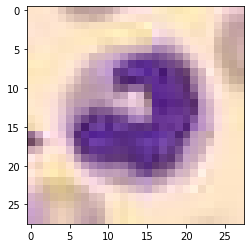

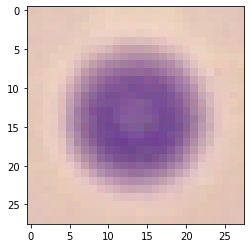

In [14]:
import matplotlib.pyplot as plt
for i, l in test_loader:
    o ,mu, v = saved_model(i)
    print(mu[0], mu[1])
    plt.imshow(i[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(o[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    break

In [15]:
class VAE_generator(nn.Module):
    def __init__(self, img_shape, code_size):
        super(VAE_generator, self).__init__()

        # encoder
        self.C, self.H, self.W = img_shape
        self.conv1 = nn.Conv2d(self.C, 32, kernel_size=3,  padding= "same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding= "same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,   padding= "same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding= "same")
        self.fc1 = nn.Linear(256, code_size)
        self.fc2 = nn.Linear(256, code_size)
        

        # decoder
        self.fc3 = nn.Linear(code_size, 2304)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding = 1)
        self.conv7 = nn.ConvTranspose2d(64, self.C, kernel_size=3, stride=2, padding=1, output_padding = 1)

    def sampling(self, mu, log_var):
        print(mu.shape)
        print(log_var.shape)
        stddev = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(stddev)
        print(stddev.shape)
        print(epsilon.shape)
#         print(epsilon.shape)
        print((stddev*epsilon).shape)
        print((mu + stddev*epsilon).shape)
        return mu + stddev*epsilon
    
    def forward(self, x,z1):
        e1 = F.elu(self.conv1(x))
        m1 = F.max_pool2d(e1, kernel_size=2)
        
        e2 = F.elu(self.conv2(m1))
        m2 = F.max_pool2d(e2, kernel_size=2)
        
        e3 = F.elu(self.conv3(m2))
        m3 = F.max_pool2d(e3, kernel_size=2)
        
        e4 = F.elu(self.conv4(m3))
        m4 = F.max_pool2d(e4, kernel_size=2)
        
        f1 = m4.view(m4.size(0), -1) 
        
        mu = self.fc1(f1)
        logvar = self.fc2(f1)
        
        z = self.sampling(mu,logvar)
        
        d5 = self.fc3(z1)
        
        d4 = d5.view(d5.size(0), 256, 3, 3)
        d3 = F.elu(self.conv5(d4))
        d2 = F.elu(self.conv6(d3))
        d1 = self.conv7(d2)
        return d1

In [16]:
z_dim = 128
saved_model = VAE_generator(img_shape = (3,28,28),code_size  = z_dim) 
saved_model.load_state_dict(torch.load('simple_vae_pytorch_model_128_code_size'))

<All keys matched successfully>

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])


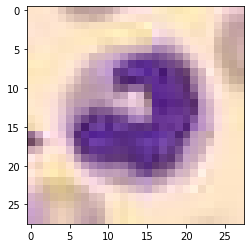

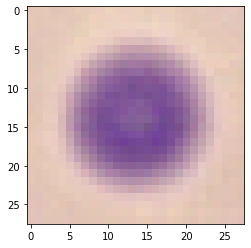

In [17]:
import matplotlib.pyplot as plt

# m = torch.randn(BATCH_SIZE, 32)
# log = torch.randn(BATCH_SIZE, 32)

z = np.random.normal(0, 1, size=(1, 128))
z = torch.Tensor(z)
# print(m.shape)
for i, l in test_loader:
#     test = torch.zeros((BATCH_SIZE,3,28,28))
    o = saved_model(i, z)
    plt.imshow(i[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(o[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    break

# Skip Connection

In [7]:
class VAE_skip(nn.Module):
    def __init__(self, img_shape, code_size):
        super(VAE_skip, self).__init__()

        # encoder
        self.C, self.H, self.W = img_shape
        self.conv1 = nn.Conv2d(self.C, 32, kernel_size=3,  padding= "same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding= "same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,   padding= "same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding= "same")
        self.fc1 = nn.Linear(256, code_size)
        self.fc2 = nn.Linear(256, code_size)
        

        # decoder
        self.fc3 = nn.Linear(code_size, 2304)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding = 1)
        self.conv7 = nn.ConvTranspose2d(64, self.C, kernel_size=3, stride=2, padding=1, output_padding = 1)

    def sampling(self, mu, log_var):
        stddev = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(stddev)
        return mu + stddev*epsilon
    
    def forward(self, x):
        e1 = F.elu(self.conv1(x))
        m1 = F.max_pool2d(e1, kernel_size=2)
        
        e2 = F.elu(self.conv2(m1))
        m2 = F.max_pool2d(e2, kernel_size=2)
        
        e3 = F.elu(self.conv3(m2))
        m3 = F.max_pool2d(e3, kernel_size=2)
        
        e4 = F.elu(self.conv4(m3))
        m4 = F.max_pool2d(e4, kernel_size=2)
        
        f1 = m4.view(m4.size(0), -1) 
        
        mu = self.fc1(f1)
        logvar = self.fc2(f1)
        z = self.sampling(mu, logvar)
        
        d5 = self.fc3(z)
        
        d4 = d5.view(d5.size(0), 256, 3, 3)
#         c1 = d4+e4
        d3 = F.elu(self.conv5(d4))
        c2 = d3+0.1*e3
        d2 = F.elu(self.conv6(c2))
#         c3 = d2+e2
        d1 = self.conv7(d2)
        return d1, mu, logvar

In [8]:
z_dim = 32
vae_skip = VAE_skip(img_shape = (3,28,28),code_size  = z_dim)

In [20]:
from torchsummary import summary
summary(vae_skip.cuda(),(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3            [-1, 128, 7, 7]          73,856
            Conv2d-4            [-1, 256, 3, 3]         295,168
            Linear-5                   [-1, 32]           8,224
            Linear-6                   [-1, 32]           8,224
            Linear-7                 [-1, 2304]          76,032
   ConvTranspose2d-8            [-1, 128, 7, 7]         295,040
   ConvTranspose2d-9           [-1, 64, 14, 14]          73,792
  ConvTranspose2d-10            [-1, 3, 28, 28]           1,731
Total params: 851,459
Trainable params: 851,459
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.53
Params size (MB): 3.25
Estimated T

In [9]:
optimizer = torch.optim.Adamax(vae_skip.parameters())
loss_fn = torch.nn.MSELoss()

In [10]:
# def train_one_epoch(epoch_index, model):
#     running_loss = 0.
#     last_loss = 0.

#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(train_loader):
#         # Every data instance is an input + label pair
#         inputs, labels = data

#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = model(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(outputs, inputs)
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()

#     last_loss = running_loss / len(train_loader) # loss per batch
#     print('Epoch {} loss: {}'.format(epoch_index, last_loss))

#     return last_loss



# def train(model, out_path):
#     # Initializing in a separate cell so we can easily add more epochs to the same run
#     epoch_number = 0

#     N_EPOCHS = 80

#     best_vloss = 1_000_000.

#     for epoch in range(N_EPOCHS):
#         print('EPOCH {}:'.format(epoch_number + 1))

#         # Make sure gradient tracking is on, and do a pass over the data
#         model.train(True)
#         avg_loss = train_one_epoch(epoch_number, model)

#         # We don't need gradients on to do reporting
#         model.train(False)

#         running_vloss = 0.0
#         for i, vdata in enumerate(val_loader):
#             vinputs, vlabels = vdata
#             voutputs = model(vinputs)
#             vloss = loss_fn(voutputs, vinputs)
#             running_vloss += vloss

#         avg_vloss = running_vloss / (i + 1)
#         print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


#         # Track best performance, and save the model's state
#         if avg_vloss < best_vloss:
#             best_vloss = avg_vloss
#             torch.save(model.state_dict(), out_path)

#         epoch_number += 1

In [37]:
train_vae(vae_skip, 'skip_vae_pytorch_model_kl_skip_1layer_0.1_weighted')

EPOCH 1:
Epoch 0 loss: 0.05842381544819433 recon_loss: 0.05020618997514248 kl_loss: 0.008217625705284474
LOSS train 0.05842381544819433 valid 0.018846161663532257 recon 0.018654940649867058 kl 0.00019122038793284446
EPOCH 2:
Epoch 1 loss: 0.018422921813310008 recon_loss: 0.018253155212134938 kl_loss: 0.00016976659987935134
LOSS train 0.018422921813310008 valid 0.017882980406284332 recon 0.017721423879265785 kl 0.0001615581859368831
EPOCH 3:
Epoch 2 loss: 0.017808140434120615 recon_loss: 0.017654153671472855 kl_loss: 0.00015398676264775942
LOSS train 0.017808140434120615 valid 0.01752801425755024 recon 0.017354007810354233 kl 0.00017400768410880119
EPOCH 4:
Epoch 3 loss: 0.017388113576612654 recon_loss: 0.017229046557762036 kl_loss: 0.0001590670073884922
LOSS train 0.017388113576612654 valid 0.017237354069948196 recon 0.01707036793231964 kl 0.0001669858756940812
EPOCH 5:
Epoch 4 loss: 0.017075672866904163 recon_loss: 0.016904773745583752 kl_loss: 0.00017089915191930119
LOSS train 0.0170

Epoch 37 loss: 0.0034875656918252574 recon_loss: 0.003413355826361947 kl_loss: 7.420986481545149e-05
LOSS train 0.0034875656918252574 valid 0.003467770991846919 recon 0.003375693690031767 kl 9.207743278238922e-05
EPOCH 39:
Epoch 38 loss: 0.0033640612175126804 recon_loss: 0.0032809632112693094 kl_loss: 8.309800689123022e-05
LOSS train 0.0033640612175126804 valid 0.0033325273543596268 recon 0.0032350250985473394 kl 9.75022412603721e-05
EPOCH 40:
Epoch 39 loss: 0.003211729909446448 recon_loss: 0.003135460666508401 kl_loss: 7.626924358590582e-05
LOSS train 0.003211729909446448 valid 0.00320149352774024 recon 0.0031392548698931932 kl 6.223803939064965e-05
EPOCH 41:
Epoch 40 loss: 0.003116472000702705 recon_loss: 0.003048677250985311 kl_loss: 6.779474906953472e-05
LOSS train 0.003116472000702705 valid 0.0031264626886695623 recon 0.003064980497583747 kl 6.148184911580756e-05
EPOCH 42:
Epoch 41 loss: 0.0029841444426382036 recon_loss: 0.0029202090410439118 kl_loss: 6.393540191822143e-05
LOSS tr

Epoch 74 loss: 0.0011288094428393428 recon_loss: 0.001118785594845165 kl_loss: 1.0023847835327615e-05
LOSS train 0.0011288094428393428 valid 0.0011913103517144918 recon 0.0011824530083686113 kl 8.857403372530825e-06
EPOCH 76:
Epoch 75 loss: 0.0011190139211727027 recon_loss: 0.0011087320434018868 kl_loss: 1.028187777081581e-05
LOSS train 0.0011190139211727027 valid 0.00114650116302073 recon 0.0011344596277922392 kl 1.204155068990076e-05
EPOCH 77:
Epoch 76 loss: 0.0010993159120927935 recon_loss: 0.0010909251342463779 kl_loss: 8.390777522485946e-06
LOSS train 0.0010993159120927935 valid 0.00119247124530375 recon 0.0011697569862008095 kl 2.2714404622092843e-05
EPOCH 78:
Epoch 77 loss: 0.0010859994496831237 recon_loss: 0.001076444296950908 kl_loss: 9.555152732215515e-06
LOSS train 0.0010859994496831237 valid 0.0011077610542997718 recon 0.0010931181022897363 kl 1.4643004760728218e-05
EPOCH 79:
Epoch 78 loss: 0.0010691662155544665 recon_loss: 0.0010590459657067509 kl_loss: 1.0120251202613572e

In [11]:
saved_model = VAE_skip(img_shape = (3,28,28),code_size  = z_dim) 
saved_model.load_state_dict(torch.load('skip_vae_pytorch_model_kl_skip_1layer_0.1_weighted'))

<All keys matched successfully>

In [14]:
running_tloss = 0.0
for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    toutputs, tmu, tlog_var = saved_model(tinputs)
    
    t_recon_loss = loss_fn(toutputs, tinputs)
    t_kl_loss = KLDivLoss(tmu, tlog_var)
    tloss = t_recon_loss + t_kl_loss
    running_tloss += t_recon_loss


avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))

LOSS test 0.001068284036591649


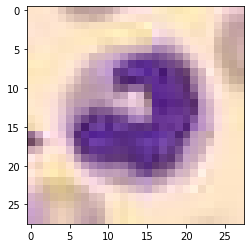

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


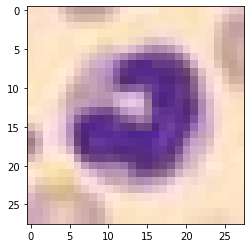

In [15]:
import matplotlib.pyplot as plt
for i, l in test_loader:
    o, mu, log = saved_model(i)
    plt.imshow(i[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(o[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    break

# Random image generation

In [27]:
class VAE_skip_generator(nn.Module):
    def __init__(self, img_shape, code_size):
        super(VAE_skip_generator, self).__init__()

        # encoder
        self.C, self.H, self.W = img_shape
        self.conv1 = nn.Conv2d(self.C, 32, kernel_size=3,  padding= "same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding= "same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,   padding= "same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding= "same")
        self.fc1 = nn.Linear(256, code_size)
        self.fc2 = nn.Linear(256, code_size)
        

        # decoder
        self.fc3 = nn.Linear(code_size, 2304)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding = 1)
        self.conv7 = nn.ConvTranspose2d(64, self.C, kernel_size=3, stride=2, padding=1, output_padding = 1)

    def sampling(self, mu, log_var):
        stddev = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(stddev)
        return mu + stddev*epsilon
    
    def forward(self, x, z1):
        e1 = F.elu(self.conv1(x))
        m1 = F.max_pool2d(e1, kernel_size=2)
        
        e2 = F.elu(self.conv2(m1))
        m2 = F.max_pool2d(e2, kernel_size=2)
        
        e3 = F.elu(self.conv3(m2))
        m3 = F.max_pool2d(e3, kernel_size=2)
        
        e4 = F.elu(self.conv4(m3))
        m4 = F.max_pool2d(e4, kernel_size=2)
        
        f1 = m4.view(m4.size(0), -1) 
        
        mu = self.fc1(f1)
        logvar = self.fc2(f1)
        z = self.sampling(mu, logvar)
        
#         z = self.sampling(z1, z2)
        
        d5 = self.fc3(z1)
        
        d4 = d5.view(d5.size(0), 256, 3, 3)
#         c1 = d4+e4
        d3 = F.elu(self.conv5(d4))
#         c2 = d3 +0.3*e3
        d2 = F.elu(self.conv6(d3))
#         c3 = d2+e2
        d1 = self.conv7(d2)
        return d1

In [28]:
z_dim= 32
saved_model = VAE_skip_generator(img_shape = (3,28,28),code_size  = z_dim) 
saved_model.load_state_dict(torch.load('skip_vae_pytorch_model_kl_skip_1layer_0.1_weighted'))

<All keys matched successfully>

In [ ]:
from torchsummary import summary
summary(saved_model.cuda(),[(3,28,28),(1,32)])

In [30]:
z = np.random.normal(0, 1, size=(1, 32))
z = torch.Tensor(z)
running_tloss = 0.0
for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    toutputs = saved_model(tinputs, z)

    t_recon_loss = loss_fn(toutputs, tinputs)
#     t_kl_loss = KLDivLoss(tmu, tlog_var)
#     tloss = t_recon_loss + t_kl_loss
    running_tloss += t_recon_loss


avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))

LOSS test 0.11207801848649979


In [ ]:
import matplotlib.pyplot as plt

z = np.random.normal(0, 1, size=(16, 32))
z = torch.Tensor(z)
# img = torch.zeros(())

for i, l in train_loader:
    test = torch.zeros((BATCH_SIZE,3,28,28))
    o = saved_model(test,z)
    print(o.shape)
#     plt.show()
    plt.imshow(test[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(o[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.show()
    
    print(i[0])
    print(o[0])
    break